# Cis-eQTL Module QTL All PCs Colocalization

**Created**: 20 May 2022

## Environment

In [1]:
library(tidyverse)
library(data.table)
library(coloc)
library(GenomicRanges)

setwd("~/eQTL_pQTL_Characterization/")

source("01_Colocalization/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


This is coloc version 5.1.1

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package:

## Load Summary Information

Load summary statistics from conditional analysis performed using COJO. Only use cis-eQTL that have the same lead eSNP.

In [2]:
geno.bim <- fread("/nfs/users/nfs_n/nm18/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.bim")

colnames(geno.bim) <- c("chr", "snp", "cM", "pos", "minor_allele", "major_allele")

In [3]:
head(geno.bim)

chr,snp,cM,pos,minor_allele,major_allele
<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,rs3131972,0,817341,A,G
1,rs546843995,0,818053,0,G
1,rs553916047,0,818359,0,A
1,1:818740_T_C,0,818740,T,C
1,rs145604921,0,819378,0,C
1,rs535256652,0,821053,0,T


In [4]:
module.ss.dir = "/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/eigengene_sva/wgcna_summary_statistics/"
module.qtl <- do.call(rbind, lapply(list.files(module.ss.dir, pattern="ME_[0-9]+_[0-9]+-.*\\.tsv"), function(file.name) {

    fread(paste0(module.ss.dir, file.name)) %>%
    as.data.frame() %>%
    dplyr::select(snp=1, beta=2, se=3, t=4, p=5) %>%
    dplyr::mutate(module.qtl=gsub("\\.tsv", "", file.name)) %>%
    dplyr::mutate(module=gsub("_[0-9]+-.*$", "", module.qtl)) %>%
    dplyr::mutate(pc=gsub("-.*$", "", gsub("ME_[0-9]+_", "", module.qtl))) %>%
    dplyr::mutate(qtl.locus=gsub("ME_[0-9]+_[0-9]+-", "", module.qtl)) %>%
    dplyr::mutate(qtl.locus.chr=gsub("\\:.*", "", qtl.locus)) %>%
    dplyr::mutate(qtl.locus.start=as.numeric(gsub(".*\\:", "", gsub("-.*$", "", qtl.locus)))) %>%
    dplyr::mutate(qtl.locus.end=as.numeric(gsub(".*-", "", qtl.locus)))
})) %>%
    merge(., geno.bim, by="snp")

In [5]:
head(module.qtl)

,snp,beta,se,t,p,module.qtl,module,pc,qtl.locus,qtl.locus.chr,qtl.locus.start,qtl.locus.end,chr,cM,pos,minor_allele,major_allele
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>
1,rs10000031,0.0019267651,0.001094589,1.7602633,0.07874832,ME_87_1-4:67472593-69475768,ME_87,1,4:67472593-69475768,4,67472593,69475768,4,0,68683231,G,A
2,rs10000031,-0.0021730771,0.002620205,-0.8293539,0.40721463,ME_87_5-4:67472593-69475768,ME_87,5,4:67472593-69475768,4,67472593,69475768,4,0,68683231,G,A
3,rs10000031,0.0003155103,0.002484468,0.1269931,0.89895231,ME_87_2-4:67472593-69475768,ME_87,2,4:67472593-69475768,4,67472593,69475768,4,0,68683231,G,A
4,rs10000031,0.0010224658,0.002528719,0.4043415,0.68610817,ME_87_3-4:67472593-69475768,ME_87,3,4:67472593-69475768,4,67472593,69475768,4,0,68683231,G,A
5,rs10000031,0.0025630543,0.002457255,1.0430561,0.29739909,ME_87_4-4:67472593-69475768,ME_87,4,4:67472593-69475768,4,67472593,69475768,4,0,68683231,G,A
6,rs10000051,-0.0016114074,0.001729396,-0.9317744,0.35160254,ME_86_5-4:117564190-120834939,ME_86,5,4:117564190-120834939,4,117564190,120834939,4,0,120370537,T,C


## Load Gene Expression and Module Eigengenes

In [6]:
gene.exp <- read.table("/lustre/scratch119/humgen/projects/gains_team282/eqtl/data/logcpm_864_20412_hla.txt")
gene.exp <- t(gene.exp)
rownames(gene.exp) <- gsub("^GA", "", rownames(gene.exp))

In [7]:
head(gene.exp)

,ENSG00000230521,ENSG00000225864,ENSG00000227766,ENSG00000237669,ENSG00000271581,ENSG00000285647,ENSG00000204435,ENSG00000231074,ENSG00000227262,ENSG00000206337,⋯,ENSG00000288253,ENSG00000288302,ENSG00000288349,ENSG00000288393,ENSG00000288398,ENSG00000288538,ENSG00000288559,ENSG00000288562,ENSG00000288573,ENSG00000288582
UK02270173_3,0.6644339,0.9817872,1.2117156,0.6420763,2.474490,0.00000000,3.704888,4.027339,0.06866465,7.318038,⋯,0.5247755,1.3000450,0.5247755,0.92735960,1.133738,1.1337380,0.9457312,0.87079780,0.31467050,2.811486
UK15130120_3,0.5827160,0.4387994,0.3068267,0.6925683,1.331531,0.03379072,4.261280,3.634898,0.25046090,6.369198,⋯,0.5125515,1.7424980,0.4883840,0.06680807,1.860177,0.6496258,0.9264084,0.06680807,0.22143010,3.343063
UK58000006_3,0.4046756,0.6022344,0.6625010,0.9792012,1.831046,0.00000000,3.719682,3.597655,0.00000000,6.837021,⋯,0.2947282,1.5250610,0.6326824,0.66250100,1.315821,1.4755270,1.0258310,0.29472820,0.13374420,4.010874
UK47010004_3,0.2090516,0.9234049,0.7996329,0.6992958,2.475317,0.05517067,4.169617,3.016982,0.30321616,7.723203,⋯,0.3032162,0.9527571,1.0911770,0.30321620,1.143029,1.8370600,0.7669565,0.25690200,0.10830900,2.610379
UK42020088_5,0.2211571,0.2211571,0.6445686,0.3765156,1.881204,0.67482702,4.527758,3.624300,0.04702687,6.350747,⋯,0.0925691,1.2174450,0.6748270,0.13671760,1.088510,2.0637890,0.8172741,0.04702687,0.22115710,2.434768
UK47490007_3,0.4288519,1.1450686,0.3130290,1.0756817,2.053137,0.00000000,4.581986,3.101136,0.00000000,6.728267,⋯,0.5012039,1.9916780,1.1895390,0.35267880,1.211271,0.7590055,0.6033524,1.02749800,0.09657541,3.816079


In [8]:
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.multiple.csv", row.names=1)

In [9]:
head(eigengenes)

,ME_1_1,ME_1_2,ME_1_3,ME_1_4,ME_1_5,ME_2_1,ME_2_2,ME_2_3,ME_2_4,ME_2_5,⋯,ME_105_1,ME_105_2,ME_105_3,ME_105_4,ME_105_5,ME_106_1,ME_106_2,ME_106_3,ME_106_4,ME_106_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UK02270173_3,0.008640296,-0.04165815,0.027430556,-0.020437463,0.018138657,0.007926439,-0.03881513,0.03058366,-0.014329184,0.009126178,⋯,0.033258706,0.010337824,0.031572946,0.0308363822,-0.01556043,-0.003317747,0.01850385,0.001776021,0.034254655,0.002439359
UK15130120_3,-0.037073495,-0.01795641,-0.007283072,-0.026494085,0.003339612,-0.033179470,-0.01991901,-0.01688432,-0.014852805,0.049310271,⋯,0.051184001,-0.001611603,0.005624913,0.0273538940,-0.03670228,-0.012327128,0.04405671,0.013144923,0.017987682,-0.001779326
UK58000006_3,0.029670524,-0.03481715,0.028491140,-0.009483861,-0.005862293,0.021490110,-0.03480085,0.03014656,-0.003961906,-0.032946862,⋯,-0.006622840,-0.045791646,0.033491934,-0.0420056572,0.02749077,-0.004740631,0.04638229,-0.043309799,0.028730908,-0.024051766
UK47010004_3,0.011954974,0.01091971,0.038665347,0.003726632,0.052019153,0.007360515,0.01763746,0.03490663,-0.005573984,-0.016190548,⋯,-0.003072117,-0.010005728,0.019263388,0.0009626484,0.06116524,0.012014706,0.01637633,-0.003045472,-0.018223178,-0.020637855
UK42020088_5,0.009818957,0.02100233,-0.019852180,-0.013052613,-0.030223051,0.008322535,0.01712902,-0.02394729,0.003193689,0.019716419,⋯,-0.032697222,-0.001257679,-0.019760950,-0.0079000979,0.02988006,0.007915598,-0.01649680,0.013250580,-0.031445321,-0.014168970
UK47490007_3,-0.021930377,0.03807246,0.042329128,-0.025160071,0.012732846,-0.024756322,0.03899339,0.03987212,-0.030754242,0.038550679,⋯,-0.003607270,0.043079589,0.025888343,0.0413386960,0.04360340,0.024871961,-0.03349057,0.029665102,-0.009251542,-0.052908888


## Generate Module and cis-eQTL Intervals

Not all PCs will have a significant association. Restrict to module-PC pairs that have a significant association.

In [10]:
n.modules <- ncol(eigengenes)

In [11]:
n.snps = system("head -n 1 /nfs/users/nfs_n/nm18/gains_team282/nikhil/data/genotypes/eigengene_sva_genotypes.raw | sed 's/ /\\n/g' | wc -l", intern=TRUE)
n.snps = as.numeric(n.snps) - 6

In [12]:
module.qtl.to.test <- module.qtl %>%
    dplyr::group_by(module.qtl) %>%
    dplyr::summarize(min.p = min(p)) %>%
    dplyr::filter(min.p < 0.05 / (n.modules * n.snps))

module.qtl <- module.qtl %>%
    dplyr::filter(module.qtl %in% module.qtl.to.test$module.qtl)

In [13]:
head(module.qtl)

,snp,beta,se,t,p,module.qtl,module,pc,qtl.locus,qtl.locus.chr,qtl.locus.start,qtl.locus.end,chr,cM,pos,minor_allele,major_allele
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>
1,rs10000031,0.0010224658,0.002528719,0.4043415,0.68610817,ME_87_3-4:67472593-69475768,ME_87,3,4:67472593-69475768,4,67472593,69475768,4,0,68683231,G,A
2,rs10000051,-0.0016114074,0.001729396,-0.9317744,0.35160254,ME_86_5-4:117564190-120834939,ME_86,5,4:117564190-120834939,4,117564190,120834939,4,0,120370537,T,C
3,rs10000051,-0.0008705945,0.001522138,-0.5719550,0.56757799,ME_86_4-4:117564190-120834939,ME_86,4,4:117564190-120834939,4,117564190,120834939,4,0,120370537,T,C
4,rs10000051,0.0006627464,0.001925217,0.3442450,0.73067472,ME_86_3-4:117564190-120834939,ME_86,3,4:117564190-120834939,4,117564190,120834939,4,0,120370537,T,C
5,rs10000051,0.0024865605,0.001218425,2.0407993,0.04154584,ME_86_1-4:117564190-120834939,ME_86,1,4:117564190-120834939,4,117564190,120834939,4,0,120370537,T,C
6,rs10000051,-0.0023474501,0.001619142,-1.4498107,0.14739496,ME_86_2-4:117564190-120834939,ME_86,2,4:117564190-120834939,4,117564190,120834939,4,0,120370537,T,C


In [14]:
module.qtl.ranges <- module.qtl %>%
    dplyr::select(chr=qtl.locus.chr, start=qtl.locus.start, end=qtl.locus.end, qtl.locus) %>%
    unique() %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

In [15]:
cis.eqtl.summary <- do.call(rbind, lapply(unique(module.qtl$qtl.locus.chr), function(chr) {
    eqtl.ss = fread(paste0("/nfs/users/nfs_n/nm18/gains_team282/nikhil/colocalization/cis_eqtl/conditional_effects/LMM/chr", chr, "_conditional_cis_eQTL_summary_statistics.tsv")) %>%
        as.data.frame() %>%
        dplyr::mutate(ID=paste0(Gene, "-", Signal))
    
    eqtl.ss.ranges = eqtl.ss %>%
        makeGRangesFromDataFrame(seqnames.field="Chr", start.field="Position", end.field="Position", keep.extra.columns=TRUE)
    
    overlaps = findOverlaps(eqtl.ss.ranges, module.qtl.ranges)
    
    result = eqtl.ss[overlaps@from, ]
    result$QTL.Locus = mcols(module.qtl.ranges)$qtl.locus[overlaps@to]
    
    return(result)
}))

In [16]:
head(cis.eqtl.summary)

,Gene,Signal,Chr,SNP,Position,Beta,SE,P_Value,ID,QTL.Locus
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
44,ENSG00000002549,1,4,rs10017860,16593256,0.019201257,0.03151489,0.5423901,ENSG00000002549-1,4:14564113-16671474
64,ENSG00000002549,1,4,rs10023986,16644735,0.042116682,0.04129068,0.3079045,ENSG00000002549-1,4:14564113-16671474
73,ENSG00000002549,1,4,rs10026224,16617798,0.036637176,0.02416366,0.1298959,ENSG00000002549-1,4:14564113-16671474
84,ENSG00000002549,1,4,rs10030983,16606705,0.002486118,0.08230272,0.9759090,ENSG00000002549-1,4:14564113-16671474
110,ENSG00000002549,1,4,rs1027784,16664709,0.002332156,0.02472518,0.9248528,ENSG00000002549-1,4:14564113-16671474
151,ENSG00000002549,1,4,rs10939675,16608964,0.027776598,0.02340553,0.2356246,ENSG00000002549-1,4:14564113-16671474


Split summary statistics by locus.

In [17]:
cis.eqtl.loci <- split(cis.eqtl.summary, cis.eqtl.summary$QTL.Locus) %>%
    lapply(., function(x) { split(x, x$ID) })

In [18]:
module.qtl.loci <- split(module.qtl, module.qtl$qtl.locus) %>%
    lapply(., function(x) { split(x, x$module.qtl) })

## COLOC

In [19]:
coloc.res <- do.call(rbind, lapply(names(module.qtl.loci), function(qtl.locus) {

    do.call(rbind, lapply(names(module.qtl.loci[[qtl.locus]]), function(module.qtl.id) {

        do.call(rbind, lapply(names(cis.eqtl.loci[[qtl.locus]]), function(cis.eqtl.id) {

            cis.eqtl.loci[[qtl.locus]][[cis.eqtl.id]] <- cis.eqtl.loci[[qtl.locus]][[cis.eqtl.id]] %>%
                dplyr::filter(!is.na(Beta))

            gene = gsub("-.*", "", cis.eqtl.id)
            me = gsub("-.*", "", module.qtl.id)

            cis.eqtl <- list()
            cis.eqtl$beta <- cis.eqtl.loci[[qtl.locus]][[cis.eqtl.id]]$Beta
            cis.eqtl$varbeta <- cis.eqtl.loci[[qtl.locus]][[cis.eqtl.id]]$SE^2
            cis.eqtl$snp <- cis.eqtl.loci[[qtl.locus]][[cis.eqtl.id]]$SNP
            cis.eqtl$position <- cis.eqtl.loci[[qtl.locus]][[cis.eqtl.id]]$Position
            cis.eqtl$type <- "quant"
            cis.eqtl$sdY <- sd(gene.exp[, gene], na.rm=TRUE)

            module.qtl <- list()
            module.qtl$beta <- module.qtl.loci[[qtl.locus]][[module.qtl.id]]$beta
            module.qtl$varbeta <- module.qtl.loci[[qtl.locus]][[module.qtl.id]]$se^2
            module.qtl$snp <- module.qtl.loci[[qtl.locus]][[module.qtl.id]]$snp
            module.qtl$position <- module.qtl.loci[[qtl.locus]][[module.qtl.id]]$pos
            module.qtl$type <- "quant"
            module.qtl$sdY <- sd(eigengenes[, me], na.rm=TRUE)

            log = capture.output({
                abf.res = suppressWarnings(coloc.abf(cis.eqtl, module.qtl))
            })

            abf.res.df = data.frame(t(abf.res$summary))
            abf.res.df$Gene = gene
            abf.res.df$eQTL.Signal = gsub(".*-", "", cis.eqtl.id)
            abf.res.df$Eigengene = me
            abf.res.df$Module.QTL = module.qtl.id

            return(abf.res.df)
        }))
    }))
}))

In [20]:
head(coloc.res)

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,Gene,eQTL.Signal,Eigengene,Module.QTL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,1952,1.133768e-46,5.985050e-10,1.088078e-38,0.0564951036,9.435049e-01,ENSG00000011021,1,ME_62_3,ME_62_3-1:10790946-12845916
2,1904,1.540254e-14,5.927282e-08,2.596939e-07,0.9993661939,6.334872e-04,ENSG00000011021,2,ME_62_3,ME_62_3-1:10790946-12845916
3,1913,2.488826e-08,2.169853e-08,4.196270e-01,0.3656319315,2.147411e-01,ENSG00000011021,3,ME_62_3,ME_62_3-1:10790946-12845916
4,396,9.381027e-01,4.627890e-02,1.344213e-02,0.0006616186,1.514656e-03,ENSG00000054523,1,ME_62_3,ME_62_3-1:10790946-12845916
5,396,9.614550e-01,2.362568e-02,1.377675e-02,0.0003377290,8.048786e-04,ENSG00000054523,2,ME_62_3,ME_62_3-1:10790946-12845916
6,1911,1.331170e-100,1.041991e-08,1.277526e-92,0.9999999894,1.627513e-10,ENSG00000083444,1,ME_62_3,ME_62_3-1:10790946-12845916


## Colocalizing Loci

In [21]:
nrow(coloc.res)

[1] 12135

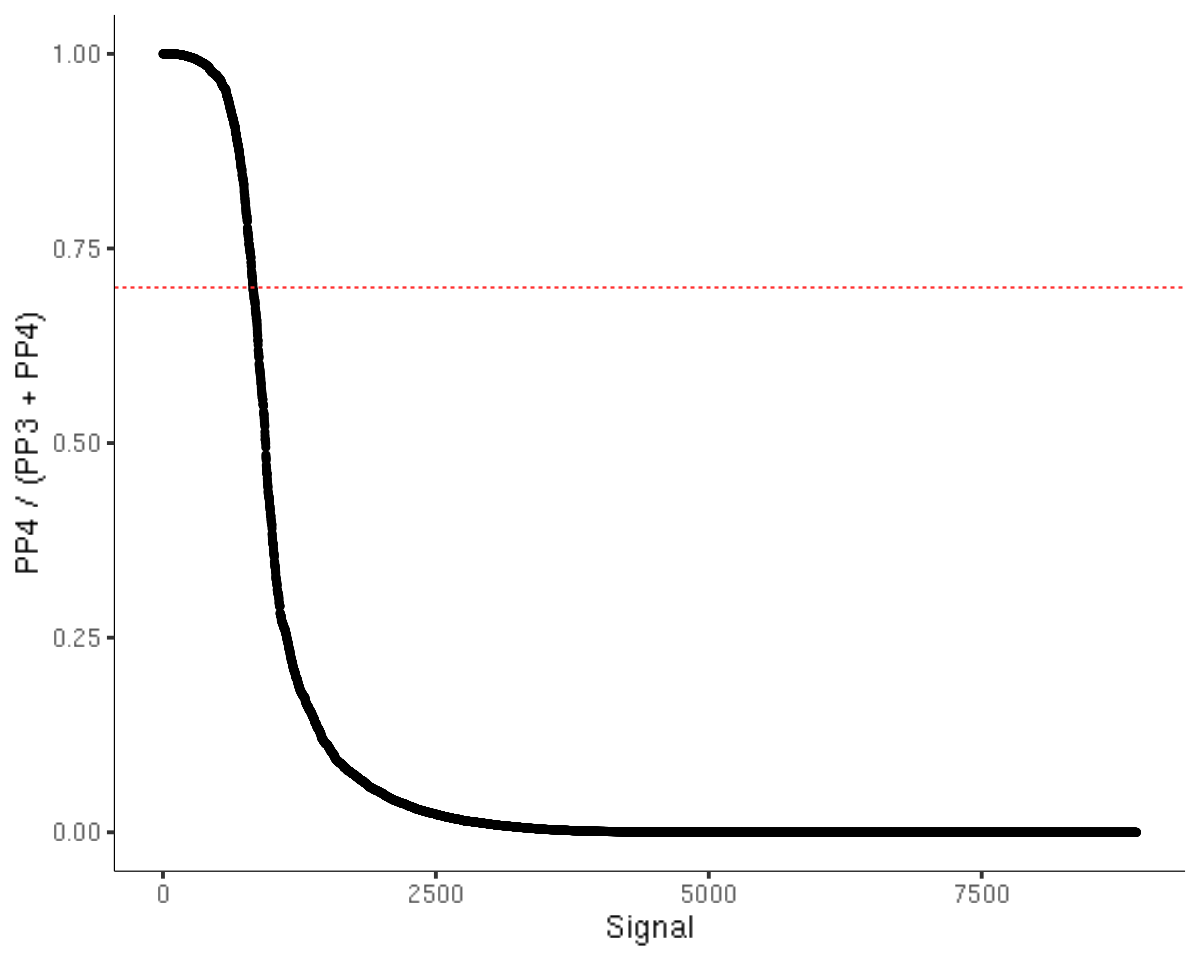

In [22]:
options(repr.plot.width=10, repr.plot.height=8)

coloc.res %>%
    dplyr::filter(PP.H3.abf + PP.H4.abf > 0.25) %>%
    dplyr::mutate(Coloc.Factor=PP.H4.abf / (PP.H3.abf + PP.H4.abf)) %>%
    dplyr::mutate(Rank=rank(-Coloc.Factor, ties.method="first")) %>%
    ggplot() +
    geom_point(aes(x=Rank, y=Coloc.Factor)) +
    geom_hline(aes(yintercept=0.7), lty=2, color="firebrick1") +
    xlab("Signal") + ylab("PP4 / (PP3 + PP4)") +
    ggplot_theme

In [23]:
colocalizing <- coloc.res %>%
    dplyr::filter(PP.H3.abf + PP.H4.abf > 0.25) %>%
    dplyr::mutate(Coloc.Factor=PP.H4.abf / (PP.H3.abf + PP.H4.abf)) %>%
    dplyr::filter(Coloc.Factor > 0.7) %>%
    dplyr::arrange(desc(Coloc.Factor))

In [24]:
head(colocalizing)

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,Gene,eQTL.Signal,Eigengene,Module.QTL,Coloc.Factor
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1725,1.325296e-105,3.679035e-80,3.602294e-29,0,1,ENSG00000142089,1,ME_106_2,ME_106_2-11:1-1332794,1
2,1706,2.701629e-145,1.739698e-110,1.552930e-38,0,1,ENSG00000251661,2,ME_106_2,ME_106_2-11:1-1332794,1
3,1695,9.885529e-160,1.739698e-110,5.682324e-53,0,1,ENSG00000254910,2,ME_106_2,ME_106_2-11:1-1332794,1
4,1695,1.538896e-98,3.679035e-80,4.182879e-22,0,1,ENSG00000254910,3,ME_106_2,ME_106_2-11:1-1332794,1
5,1724,2.803508e-134,1.739698e-110,1.611491e-27,0,1,ENSG00000255328,3,ME_106_2,ME_106_2-11:1-1332794,1
6,1722,1.886565e-163,1.739698e-110,1.084421e-56,0,1,ENSG00000270030,1,ME_106_2,ME_106_2-11:1-1332794,1


In [25]:
write.csv(colocalizing, "~/gains_team282/nikhil/colocalization/cis_eqtl_module_qtl.csv", row.names=F)

In [26]:
nrow(colocalizing)

[1] 824

There are 361 eGenes that colocalize with at least one module QTL.

In [27]:
length(unique(colocalizing$Gene))

[1] 361

There are 74 module-locus pairs.

In [28]:
length(unique(gsub("_[0-5]-", "-", colocalizing$Module.QTL)))

[1] 74

There are 48 modules in total.

In [29]:
length(unique(gsub("_[0-5]-.*", "", colocalizing$Module.QTL)))

[1] 48

## Distribution of Locus Counts

In [30]:
loci.counts <- colocalizing %>%
    dplyr::mutate(Module.QTL.Locus=gsub("_[0-5]-", "-", Module.QTL)) %>%
    dplyr::select(Module.QTL.Locus, Gene, eQTL.Signal) %>%
    unique() %>%
    dplyr::group_by(Module.QTL.Locus) %>%
    dplyr::summarize(Count=n()) %>%
    dplyr::arrange(desc(Count))

median(loci.counts$Count)
range(loci.counts$Count)

[1] 4

[1]  1 27

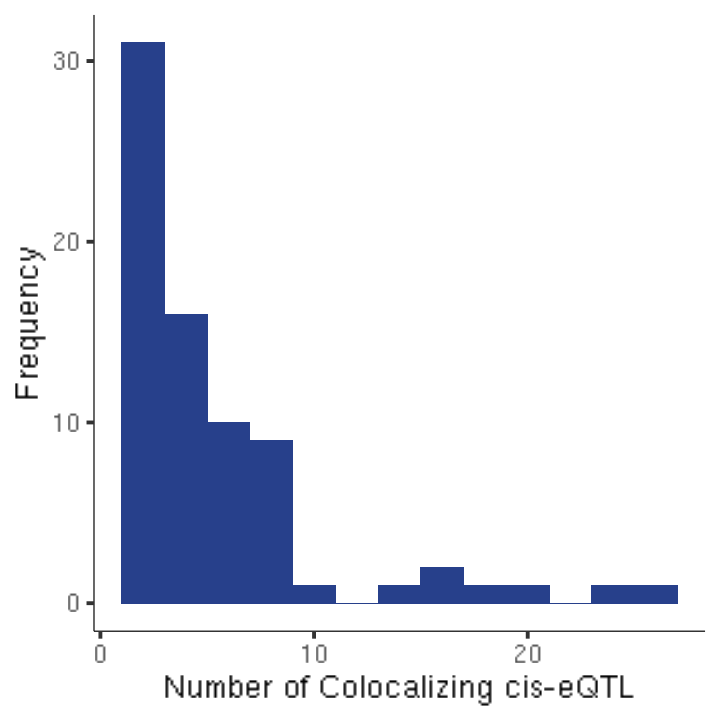

In [46]:
options(repr.plot.width=6, repr.plot.height=6)

loci.counts %>%
    ggplot() +
    geom_histogram(aes(x=Count), binwidth=2, fill="royalblue4") +
    xlab("Number of Colocalizing cis-eQTL") + ylab("Frequency") +
    ggplot_theme

ggsave("01_Colocalization/results/module_qtl_cis_eqtl_colocalization_distribution.pdf", width=6, height=6)

## eGene Membership in Modules

In [32]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")
rownames(modules) <- modules$Gene

In [33]:
egenes.in.module <- colocalizing %>%
    dplyr::mutate(Gene.Module = modules[Gene, "Module"]) %>%
    dplyr::mutate(Eigengene.Module = paste0("Module_", gsub("_[0-5]$", "", gsub("ME\\_", "", Eigengene)))) %>%
    dplyr::mutate(Module.QTL.Locus = gsub("_[0-5]-", "-", Module.QTL)) %>%
    dplyr::select(Module.QTL.Locus, Gene.Module, Eigengene.Module) %>%
    dplyr::group_by(Module.QTL.Locus) %>%
    dplyr::summarize(
        eGene.In.Module=any(Gene.Module == Eigengene.Module),
        Prop.eGenes.In.Module=sum(Gene.Module == Eigengene.Module) / n(),
        eGene.Not.In.Module=any(Gene.Module != Eigengene.Module)
    )
head(egenes.in.module)

Module.QTL.Locus,eGene.In.Module,Prop.eGenes.In.Module,eGene.Not.In.Module
<chr>,<lgl>,<dbl>,<lgl>
ME_100-2:177556567-179584183,TRUE,1.0000000,FALSE
ME_101-1:24243590-26454176,TRUE,0.6666667,TRUE
ME_101-12:54985643-57100037,TRUE,0.6666667,TRUE
ME_101-15:30215896-32681425,TRUE,0.1428571,TRUE
ME_102-17:17145294-19676395,TRUE,0.5833333,TRUE
ME_103-12:68275923-70376531,TRUE,1.0000000,FALSE


In [34]:
sum(egenes.in.module$eGene.In.Module)

[1] 70

In [35]:
sum(egenes.in.module$eGene.Not.In.Module)

[1] 40

In [36]:
median(egenes.in.module$Prop.eGenes.In.Module)

[1] 0.8888889

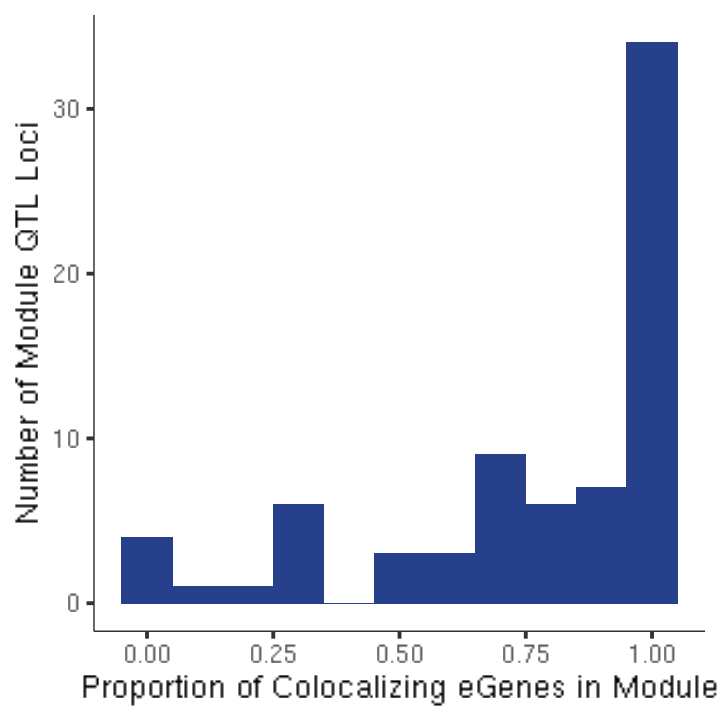

In [47]:
options(repr.plot.width=6, repr.plot.height=6)

egenes.in.module %>%
    ggplot() +
    geom_histogram(aes(x=Prop.eGenes.In.Module), binwidth=0.1, fill="royalblue4") +
    xlab("Proportion of Colocalizing eGenes in Module") + ylab("Number of Module QTL Loci") +
    ggplot_theme

ggsave("01_Colocalization/results/module_qtl_colocalization_module_membership_distribution.pdf", width=6, height=6)

## Colocalization Association Plots

In [38]:
geno <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/data/genotypes/eigengene_sva_ss_genotypes.raw", sep=" ", drop=2:6)
colnames(geno) <- gsub(":", "_", gsub("\\_.*", "", colnames(geno)))

geno <- as.data.frame(geno)
colnames(geno) <- gsub("X", "", colnames(geno))
rownames(geno) <- gsub("^GA", "", geno[, 1])
geno[, 1] <- NULL

In [39]:
module.egenes <- colocalizing %>%
    dplyr::mutate(eQTL=paste0(Gene, "-", eQTL.Signal)) %>%
    dplyr::select(eQTL, Module.QTL) %>%
    dplyr::group_by(Module.QTL) %>%
    dplyr::summarize(eQTL=paste0(eQTL, collapse=","))

module.egenes.map <- lapply(1:nrow(module.egenes), function(i) { unlist(strsplit(module.egenes$eQTL[i], ",")) })
names(module.egenes.map) <- module.egenes$Module.QTL

In [40]:
names(module.egenes.map)[grepl("ME_103", names(module.egenes.map))]

[1] "ME_103_1-12:68275923-70376531" "ME_103_2-12:68275923-70376531"
[3] "ME_103_3-12:68275923-70376531" "ME_103_4-12:68275923-70376531"
[5] "ME_103_5-12:68275923-70376531"

In [41]:
module.qtl = "ME_103_1-12:68275923-70376531"

In [42]:
qtl.locus <- gsub("ME_.*_[0-5]+-", "", module.qtl)
assoc <- dplyr::bind_rows(
    module.qtl.loci[[qtl.locus]][[module.qtl]] %>%
        dplyr::select(snp, pos, p, qtl=module.qtl),
    do.call(rbind, cis.eqtl.loci[[qtl.locus]]) %>%
        dplyr::select(snp=SNP, pos=Position, p=P_Value, qtl=ID) %>%
        dplyr::filter(qtl %in% module.egenes.map[[module.qtl]])
) %>%
    dplyr::mutate(log10p=-log10(p))

In [43]:
snp.set <- unique(assoc$snp)
ld <- cor(geno[,snp.set], use="pairwise.complete.obs")

ld.info <- do.call(rbind, assoc %>%
    dplyr::group_by(qtl) %>%
    dplyr::slice_min(p, n=1, with_ties=F) %>%
    apply(., 1, function(x) {
        as.data.frame(ld[, x[1]]) %>%
            dplyr::select(ld=1) %>%
            dplyr::mutate(snp=rownames(.), qtl=x[4], ld=ld^2)
    })
)

In [44]:
module.egenes.map[[module.qtl]]

[1] "ENSG00000090382-1" "ENSG00000274979-1" "ENSG00000257764-2"

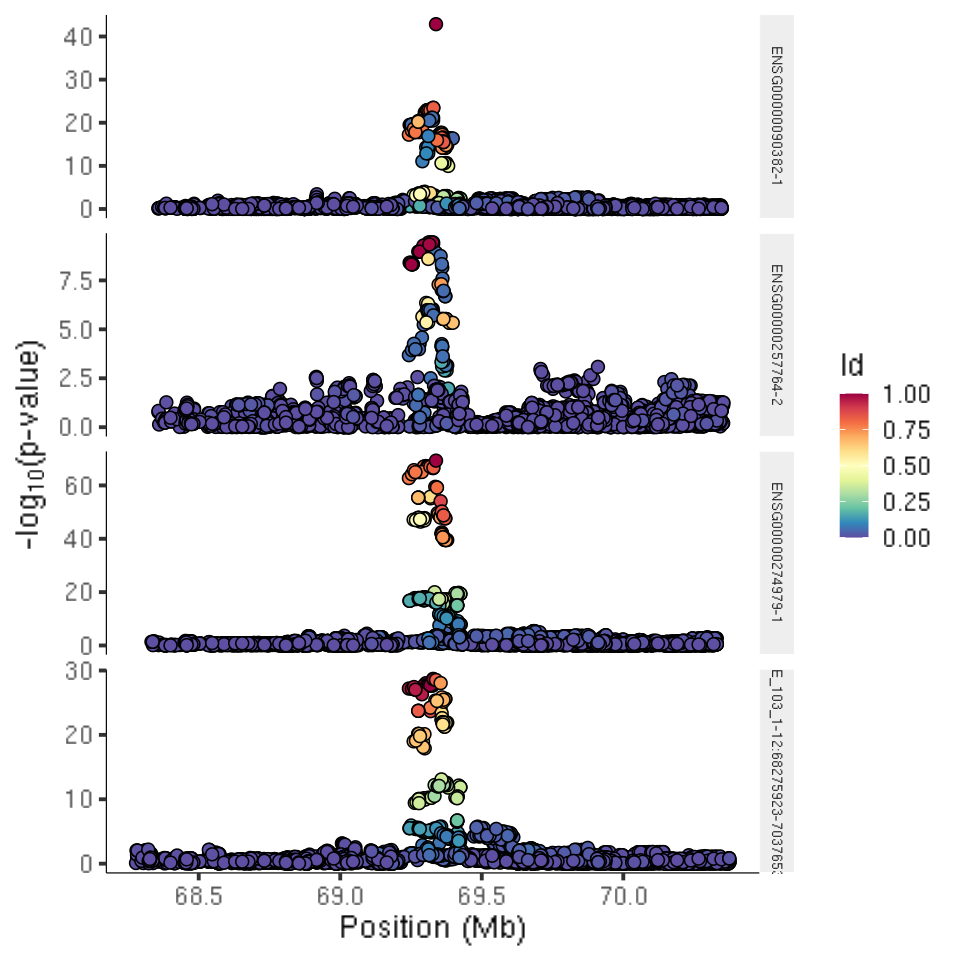

In [45]:
options(repr.plot.width=8, repr.plot.height=8)

palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(11, "Spectral")))

merge(assoc, ld.info, by=c("snp", "qtl")) %>%
    ggplot() +
    geom_point(aes(x=pos / 10^6, y=log10p, fill=ld), pch=21, size=3) +
    scale_fill_gradientn(colors=palette(100), limits=c(0, 1)) +
    xlab("Position (Mb)") + ylab(bquote("-log"[10]*"(p-value)")) +
    facet_grid(qtl ~ ., scales="free_y") +
    ggplot_theme +
    theme(legend.position="right", strip.text.y=element_text(size=8))